In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../')
from utils.packages import *

def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

global_params = {
    'max_seq_len': 64,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 10,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': 'cuda' #change this to run on cuda #'cuda:0'
}

dataset_name = 'Synthea/Small_cohorts/'

feature_types = {'diagnosis':True, 'medications':False, 'procedures':False}

if (feature_types['diagnosis'] and feature_types['medications']):
    print("Do only use diagnosis")
    code_voc = 'MLM_diagnosmedcodes.npy'
    age_voc = 'MLM_age.npy'

elif (feature_types['diagnosis'] and not feature_types['medications']):
    code_voc = 'MLM_diagnoscodes.npy'
    age_voc = 'MLM_age.npy'

else:
    code_voc = 'MLM_diagnosmedproccodes.npy'
    age_voc = 'MLM_age.npy'

files = {'code':'../data/vocabularies/' + dataset_name + code_voc,
             'age':'../data/vocabularies/' + dataset_name + age_voc,
        }

tokenizer = EHRTokenizer(task='MLM', filenames=files)

model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':False,
        'reg':0.1,
        'age':True,
        'gender':False,
        'epochs':20,
    }

stats_path = '../data/datasets/Synthea/Small_cohorts/train_stats/'
condfiles = {'dd':stats_path + 'dd_cond_probs.empirical.p', 
             'dp':stats_path + 'dp_cond_probs.empirical.p',
             'dm':stats_path + 'dm_cond_probs.empirical.p',
             'pp':stats_path + 'pp_cond_probs.empirical.p', 
             'pd':stats_path + 'pd_cond_probs.empirical.p',
             'pm':stats_path + 'pd_cond_probs.empirical.p',
             'mm':stats_path + 'mm_cond_probs.empirical.p', 
             'md':stats_path + 'md_cond_probs.empirical.p',
             'mp':stats_path + 'mp_cond_probs.empirical.p',
            }

/var/local/home/linler17/.conda/envs/masterenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#train, val, test = train_test_val_split(dataset, train_ratio=0.6, validation_ratio=0.2, test_ratio=0.2)
path='../data/datasets/' + dataset_name
path

'../data/datasets/Synthea/Small_cohorts/'

In [4]:
train = pd.read_parquet(path + 'train.parquet')
val = pd.read_parquet(path + 'val.parquet')
test = pd.read_parquet(path + 'test.parquet')

viz_data = pd.concat([train, val, test])
folderpath = '../data/pytorch_datasets/' + dataset_name
vizdataset = EHRDataset(viz_data, max_len=train_params['max_len_seq'], run_type='all_data', save_folder=folderpath,feature_types=feature_types, conditional_files=condfiles, tokenizer=tokenizer)
vizloader = torch.utils.data.DataLoader(vizdataset, batch_size=1, pin_memory=True, shuffle=True)

conf = BertConfig(model_config)
model = BertForMaskedLM(conf)
PATH = "../saved_models/MLM/BEHRT_Synthea"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

Loading data


t_total value of -1 results in schedule not being applied


In [6]:
iterr = iter(vizloader)

In [99]:
datapoint = next(iterr)

In [100]:
age, gender, code, position, segment, mask, label, prior_guide = datapoint

In [101]:
loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)

In [200]:
sentence = tokenizer.convert_ids_to_tokens(code.numpy().squeeze(), 'code')
lastatt = attention_scores[-1]
averagedlastatt = ((lastatt.sum(dim=1) / lastatt.shape[1])[0]).detach().numpy()

In [201]:
averagedlastatt.shape

(64, 64)

In [202]:
attindex = 43

In [203]:
atttoken = sentence[attindex]

In [204]:
choseonetoken = averagedlastatt[attindex, :]

In [205]:
mapdata = pd.read_csv('../data/mapping_data/Synthea/unique_conds.csv')
mapdata['CODE'] = mapdata['CODE'].map(str)
code_to_desc = dict(zip(mapdata.CODE,mapdata.DESCRIPTION))

In [206]:
values = []
word = []
for idx, (prob, token) in enumerate(zip(choseonetoken, sentence)):
    if token == '[PAD]':
        continue
    if token in code_to_desc:
        token = code_to_desc[token]
    #print(idx, token)    
    word.append(token)
    values.append(prob)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


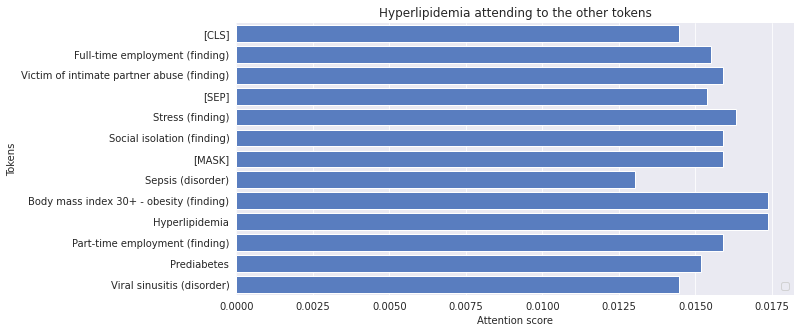

In [207]:
f, ax = plt.subplots(figsize = (10,5))
plt.xlabel('Attention score')
plt.ylabel('Tokens')
plt.title('{} attending to the other tokens'.format(code_to_desc[atttoken]))
sns.set_style('darkgrid')
sns.set_palette('Set2')
sns.barplot(x = values, y = word, color = 'b', edgecolor = 'w', ci = None)
#ax.set_box_aspect(10/5) #change 10 to modify the y/x axis ratio
sns.set_color_codes('muted')
#sns.barplot(x = 'alcohol', y = 'abbrev', data = crashes,
 #           label = 'Alcohol-involved', color = 'b', edgecolor = 'w')
ax.legend(ncol = 1, loc = 'lower right')
sns.despine(left = True, bottom = True)
plt.show()